# Calc_ModalNRJ_subdom

investigate modal NRJ content and transfert terms, globally and per subdomain

Conversion terms (free surface, cf Kelly 2016):
$$ C_{mn} = u_mp_n\cdot\int\phi_m\nabla\phi_n - u_np_m\cdot\int\phi_n\nabla\phi_m $$

Adapted from a previous version (Diag_ModalNRJ_subdom). Now this notebook do all the calculation and store the results in a netCDF and csv files

See Plot_ModalNRJ_subdom.ipynb for the plots, and other notebooks as well

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

import numpy as np
import sys, os
from netCDF4 import Dataset#, MFDataset
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import scipy.interpolate as itp
from PIL import Image, ImageDraw
import json
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [2]:
# informations

simul = "luckym2"

data_bcl = KRYPTON+'DIAG/NRJ_fluxes/{0}_puv_fluxes_hf.?.nc'.format(simul)
data_btr = KRYPTON+'DIAG/NRJ_fluxes/{0}_bt_fluxes.?.nc'.format(simul)
data_mod = KRYPTON+'{0}_modemap/{0}_modemap_20.nc'.format(simul)
data_nrj = KRYPTON+'{0}_modemap/{0}_modenrj_20.nc'.format(simul)

grid_file = KRYPTON+"/lucky_corgrd.nc"
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
dirpic = 'pictures/modal_conv_scatter/'
dosavefig = False
dostore = True # store results in a netcdf file and in a csv file

filout = KRYPTON+'{0}_modemap/{0}_mode_scatdiag.nc'.format(simul)
doappend = False
csvout = "./{}_diagscat.csv".format(simul)
data_Fa14 = KRYPTON+"Tide_Conv/Falahat_etal_2014_ModalConvM2.nc"

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)
      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)

cols = pd.MultiIndex
datfra = pd.DataFrame(index=['full']+nams)

rho0 = 1025


In [3]:
# load stuf and declare useful functions
imod = 0 #slice(1,10)
rho0 = 1025.

nc = Dataset(data_nrj,'r')
print(nc.variables["ocean_time"][:])
times = nc.variables['time'][:]
nt = len(times)
modes = nc.variables['mode'][:]
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
nc.close()

indt = np.arange(nt-60-24*5, nt-60)

# load topo
ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
dx = np.mean(1./ncgrd.variables['pm'][:,xi][eta,:])
dy = np.mean(1./ncgrd.variables['pn'][:,xi][eta,:])
dhdx = (np.gradient(ncgrd.variables['h'][:], axis=1)/dx)[:,xi][eta,:]
dhdy = (np.gradient(ncgrd.variables['h'][:], axis=0)/dy)[:,xi][eta,:]
ncgrd.close()
subsamp_step = np.diff(xi[:2])[0]
dx *= np.diff(xi[:2])[0]
dy *= np.diff(eta[:2])[0]
print("shape :",topo.shape)

mast = topo<100
nmod = len(modes)
ny, nx = topo.shape

# local routines (need lon, lat before for convienence)
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item, lon, lat) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(topo>100)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))

# declare pandas dataframe, initializing with a few fields
index = pd.MultiIndex.from_product([['Etot','KE','PE'],['full']+nams], names=['field', 'domain'])
datfra = pd.DataFrame(index=modes, columns=index)


[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.
   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
   84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
   96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
  108.  109.  110.  111.  112.  113.  114.  115.  116.  117.  118.  119.
  120.  121.  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.
  132.  133.  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.
  144.  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.
  156.  157.  158.  159.  160.  161.  162.  163.  1

In [4]:
# getting netCDF file ready for storing values
if dostore and (not os.path.isfile(filout) or doappend):
    ncw = Dataset(filout, "w")
    ncw.createDimension("xi_rho", nx)
    ncw.createDimension("eta_rho", ny)
    ncw.createDimension("mode", len(modes))
    ncwar = ncw.createVariable("xi_rho", "i", ("xi_rho",))
    ncwar.long_name = "xi indices in simulation grid"
    ncwar[:] = xi
    ncwar = ncw.createVariable("eta_rho", "i", ("eta_rho",))
    ncwar.long_name = "eta indices in simulation grid"
    ncwar[:] = eta
    ncw.createVariable('lon_rho', 'f', ('eta_rho','xi_rho'))[:] = lon    
    ncw.createVariable('lat_rho', 'f', ('eta_rho','xi_rho'))[:] = lat
    ncw.generated_on = datetime.today().isoformat()
    ncw.generating_script = "Calc_ModalNRJ_subdom.ipynb"
    ncw.from_files = [data_bcl, data_btr, data_mod, data_nrj, grid_file, doms_file]
    ncw.simul_name = simul
    ncw.dxdy_subsamp = (dx, dy)
    ncw.subsamp_step = subsamp_step
    ncw.close()


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


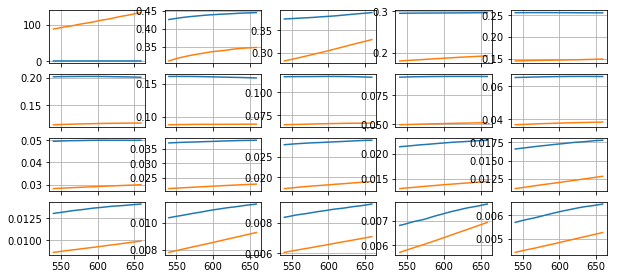

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


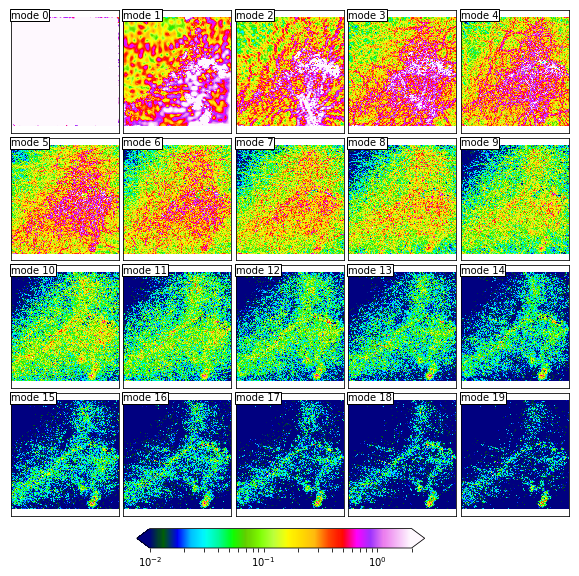

In [5]:
# just visualizing modal NRJ 
# warning barotropic PE NRJ is probably wrong

nc = Dataset(data_nrj,'r')
prov = nc.variables['ek_lf'][indt,...]
ektser = np.nanmean(prov, axis=(-1,-2))
kemod = prov.mean(axis=0)
prov = nc.variables['ep_lf'][indt,...]
eptser = np.nanmean(prov, axis=(-1,-2))
pemod = prov.mean(axis=0)
etmod = kemod+pemod
nc.close()

fig, axs = plt.subplots(4, (nmod+1)//4, sharex=True, figsize=(2*(nmod+1)//4, 4.5))
for ia,ax in enumerate(axs.ravel()):
    ax.plot(times[indt], ektser[:,ia], times[indt], eptser[:,ia])
    ax.grid(True)

fig, axs = plt.subplots(4, (nmod+1)//4, sharex=True, sharey=True, figsize=(2*(nmod+1)//4, 4.5*2))
for ia,ax in enumerate(axs.ravel()):
    vmax = 10 if ia==0 else 2
    hpc = ax.pcolormesh(np.ma.masked_where(mast,etmod[ia,:,:]), norm=colors.LogNorm(vmin=1e-2, vmax=vmax), cmap="gist_ncar")
    ax.text(0, 1, "mode {}".format(ia), va='top', transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    ax.set_aspect(1)

for ax in axs.ravel():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
fig.subplots_adjust(bottom=0.1, wspace=.04, hspace=.04)
cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.03])
ac = fig.colorbar(hpc, cax=cbar_ax, orientation="horizontal", extend="both")


In [6]:
# store ke, pe and te in dataframe and netCDF file
       
for fie,val in zip(["Etot","KE","PE"],[etmod,kemod,pemod]):
    datfra[fie,'full'] = [np.nanmean(np.ma.masked_where(mast,val[ia,:,:])) for ia in range(nmod)]
    for nam,dom in zip(nams,doms):
        datfra[fie,nam] = get_domean(val, dom, lon=lon, lat=lat, masksup=~mast)

if dostore:
    ncw = Dataset(filout, "a")
    for var,val in zip(["KE","APE","TotE"], [kemod,pemod,etmod]):
        if (not doappend) and (var not in ncw.variables):
            ncwar = ncw.createVariable(var, "f", ("mode","eta_rho","xi_rho"))
            ncwar.longname = "modal energy"
            ncwar.units = "kJ/m^2"
        else:
            ncwar = ncw.variables[var]
        ncwar[:] = val
        ncwar.ind_t_avg = (indt[0], indt[-1])
    ncw.close()

<Container object of 20 artists>

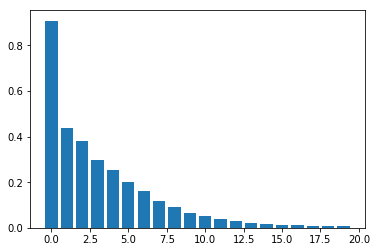

In [7]:
# bar plot of mean KE content
plt.figure()
plt.bar(modes[0:], np.nanmean(kemod[0:,...],axis=(1,2)))

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


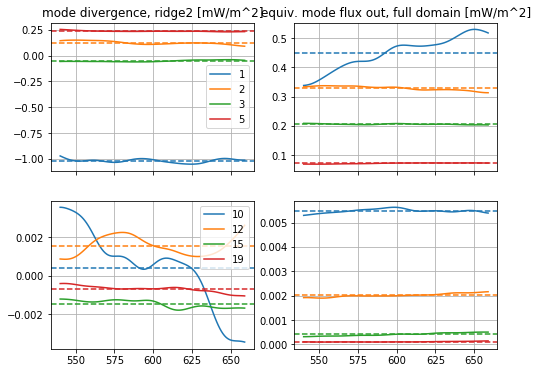

In [8]:
# plot flux divegence (take AVG)
doblur = True
siglur = 2
indt = np.arange(nt-60-24*5, nt-60)

nc = Dataset(data_nrj,'r')
#divfmod = (np.gradient(nc.variables['Fx_avg'][:], axis=2)/dx + np.gradient(nc.variables['Fy_avg'][:], axis=1)/dy)*1e3
divfmod = (np.gradient(nc.variables['Fx_lf'][indt,...], axis=-1)/dx 
           + np.gradient(nc.variables['Fy_lf'][indt,...], axis=-2)/dy)*1e3#*rho0 # W/m²
fmodout = (np.diff(nc.variables['Fx_lf'][indt,...][...,:,[0,nx-1]],axis=-1).sum(axis=(-1,-2))/dx \
            + np.diff(nc.variables['Fy_lf'][indt,...][...,[0,ny-1],:],axis=-2).sum(axis=(-1,-2))/dy)*1e3/(nx*ny)
nc.close()

# plot time series for modes 1, 2, 10 and 19 over ridge2
imods = [1, 2, 3, 5, 10, 12, 15, 19]
prov = np.zeros((len(indt),len(imods)))
for imo,mod in enumerate(imods):
    prov[:,imo] = get_domean(divfmod[:,mod,...],doms[nams.index("ridge2")])
divfmod = divfmod.mean(axis=0)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,6))
for imo,mod in enumerate(imods):
    ax = axs[int(mod>=10),0]
    hpl, = ax.plot(times[indt], prov[:,imo]*1e3, label=str(mod))
    ax.axhline(prov[:,imo].mean()*1e3, linestyle="--", color=hpl.get_color())
    ax = axs[int(mod>=10),1]
    hpl, = ax.plot(times[indt], fmodout[:,mod]*1e3)
    ax.axhline(fmodout[:,mod].mean()*1e3, linestyle="--", color=hpl.get_color())
for ax in axs.ravel():
    ax.grid(True)
    ax.legend()
axs[0,0].set_title('mode divergence, ridge2 [mW/m^2]')
axs[0,1].set_title('equiv. mode flux out, full domain [mW/m^2]')

if dostore:
    ncw = Dataset(filout, "a")
    var, val = "divf", divfmod
    if (not doappend) and (var not in ncw.variables):
        ncwar = ncw.createVariable(var, "f", ("mode","eta_rho","xi_rho"))
        ncwar.longname = "modal energy flux divergence"
        ncwar.units = "W/m^2"
    else:
        ncwar = ncw.variables[var]
    ncwar[:] = val
    ncwar.ind_t_avg = (indt[0], indt[-1])
    ncw.close()

sum over baroclinic modes: 6.06e-05


domain          full           out        ridge1        ridge2        ridge3  \
0       4.815710e-03  4.983150e-03  5.387458e-03 -1.730888e-04 -4.945951e-03   
1       3.292280e-04  4.483912e-04 -9.020552e-04 -1.018362e-03  4.503677e-04   
2       3.217573e-04  3.284572e-04  1.342298e-04  1.241402e-04 -2.639843e-05   
3       2.059696e-04  2.056405e-04  3.186309e-04 -5.195680e-05  5.591295e-05   
4       1.196108e-04  1.214745e-04  3.333747e-04  2.729623e-04  1.319457e-04   
5       6.928333e-05  7.210754e-05  1.679350e-04  2.362192e-04  1.695052e-06   
6       4.419559e-05  4.683270e-05  1.157817e-04  2.646137e-05  1.287549e-05   
7       2.578940e-05  2.778053e-05  8.058103e-05  4.390214e-05 -9.144484e-06   
8       1.611002e-05  1.755027e-05  6.474602e-05  1.356620e-05  2.464265e-06   
9       7.846104e-06  9.423716e-06  3.943555e-05 -1.227677e-05 -2.444757e-06   
10      4.318747e-06  5.474508e-06  2.632410e-05  4.164377e-07 -4.928593e-06   
11      2.538173e-06  3.380781e-06  1.374358e-05 -1.951906e-06 -5.041494e-06   
12      1.472253e-06  2.016833e-06  8.177122e-06  1.558377e-06 -1.385722e-06   
13      7.608428e-07  1.199344e-06  5.792336e-06 -1.829362e-06  5.715753e-08   
14      4.059392e-07  6.515116e-07  5.113025e-06 -1.481958e-06 -1.165971e-06   
15      2.244409e-07  4.112795e-07  2.880240e-06 -1.473352e-06 -7.031688e-07   
16      2.242538e-07  3.034902e-07  2.949309e-06 -1.541411e-06 -4.618460e-08   
17      1.239167e-07  2.129556e-07  1.568072e-06 -7.376747e-07 -2.424768e-07   
18      1.561467e-07  1.680309e-07  1.387529e-06 -1.205018e-06 -2.946108e-07   
19      8.883071e-08  1.103357e-07  5.956313e-07 -6.937527e-07 -3.523504e-08   

domain    ridge4  seamounts       islands         plain  
0       0.003095  -0.026404 -2.038165e-02  1.198421e-02  
1      -0.000059   0.012648 -1.409731e-03  6.169314e-05  
2       0.000295   0.005473  1.049488e-03  3.152770e-05  
3       0.000364   0.002113  7.754418e-04 -1.601574e-05  
4       0.000534   0.001033  3.021354e-04 -4.442471e-05  
5       0.000310   0.000235  1.902129e-04 -2.415354e-05  
6       0.000182   0.000244  3.797466e-05 -5.469051e-05  
7       0.000084   0.000117 -2.823923e-06 -2.139739e-05  
8       0.000065   0.000056  6.331421e-06 -2.864965e-05  
9       0.000044   0.000042 -7.835146e-06 -1.948224e-05  
10      0.000021   0.000030 -6.963621e-06 -1.360846e-05  
11      0.000016   0.000022 -7.646964e-06 -9.526919e-06  
12      0.000007   0.000015 -4.705782e-06 -5.830299e-06  
13      0.000007   0.000009 -3.908252e-06 -4.769097e-06  
14      0.000004   0.000008 -2.049871e-06 -2.748754e-06  
15      0.000004   0.000006 -1.464715e-06 -2.155328e-06  
16      0.000002   0.000004 -1.153350e-06 -1.552701e-06  
17      0.000002   0.000003 -1.001470e-06 -1.228662e-06  
18      0.000001   0.000002 -1.300278e-07 -6.531585e-07  
19      0.000001   0.000002 -6.140307e-07 -5.976686e-07

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


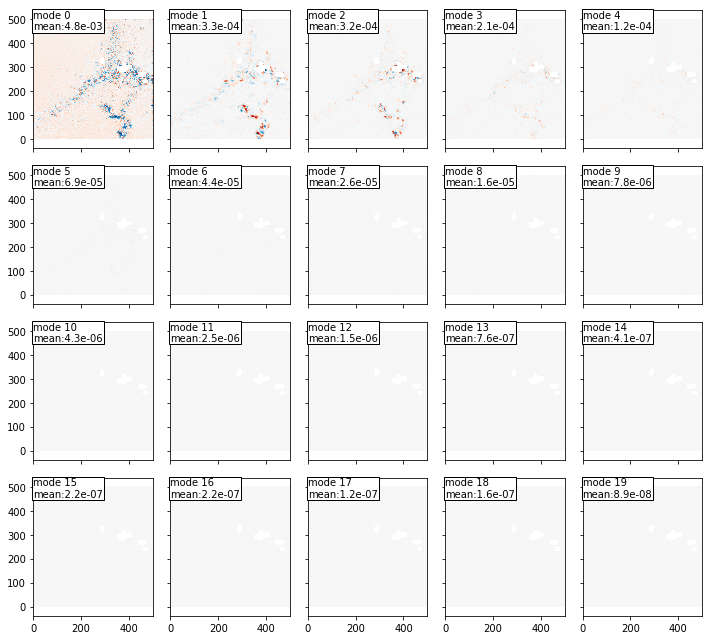

In [9]:
# compute over subdomains (will be exploited later)
divfmoy = {"full":np.nanmean(divfmod[:,~mast],axis=-1), "out":fmodout.mean(axis=0)}

for nam,dom in zip(nams,doms):
    divfmoy[nam] = get_domean(divfmod,dom)
for nam in ["full","out"]+nams:
    datfra['divF',nam] = divfmoy[nam]
    
# plot it
vamp = 10*np.nanstd(divfmod[1,...])
norm = colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)

fig, axs = plt.subplots(4, (nmod+1)//4, sharex=True, sharey=True, figsize=(2*(nmod+1)//4, 2*4.5))
for ia,ax in enumerate(axs.ravel()):
    toplot = np.ma.masked_where(mast,divfmod[ia,:,:])
    ax.text(0, 1, "mode {0} \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    if doblur:
        toplot = gaussian_filter(toplot, sigma=siglur)
    ax.pcolormesh(toplot, norm=norm, cmap="RdBu_r")
    ax.set_aspect(1)
    
fig.set_tight_layout(True)

print("sum over baroclinic modes: {:.2e}".format(np.nanmean(divfmod[1:,...])))

datfra['divF']

In [10]:
# compute every Cmn and take the mean value
# compute conversion term (no filtering) and lowpass filter / average

indm = range(nmod)
doblur = True
siglur = 2

# set up filter
dt = 1
filtperiod = 30 # in hours
bb, aa = sig.butter(4, 2*dt/30)
# m=0, n
nc = Dataset(data_mod, "r")
umod = nc.variables['u_amp']
vmod = nc.variables['v_amp']
pmod = nc.variables['p_amp']

zrho = nc.variables['zrb']

# ctmn is Cmn, with m along 1st indiex, n along 2nd index
ctmn = {nam:np.zeros((len(indm),len(indm))) for nam in nams+["full"]}

# get netCDF file ready
if dostore:
    ncw = Dataset(filout, "a")
    var = "Cmn"
    if (not doappend) and (var not in ncw.variables):
        ncwar = ncw.createVariable(var, "f", ("mode","mode","eta_rho","xi_rho"))
        ncwar.longname = "modal energy flux divergence"
        ncwar.expl = "m is first dim, n is second dim, m to n conversion, antisymmetric matrix"
        ncwar.units = "W/m^2"
    else:
        ncwar = ncw.variables[var]
    ncwar.ind_t_avg = (indt[0], indt[-1])
    ncwar.lowpass_filt_t = filtperiod
    ncwar.lowpass_filt_t_expl = "inverse cutoff frequency of lowpass filter [h]"
    ncw.close()
    
for imod in indm:
    print("now doing mode",imod,flush=True)
    phim = nc.variables['p_modes'][imod,0,...]
    lam = 1./nc.variables["mode_speed"][imod,...]**2
    for inod in indm[imod+1:]:
        if inod==imod: continue
        lan = 1./nc.variables["mode_speed"][inod,...]**2
        phin = nc.variables['p_modes'][inod,0,...]
        prav = phim*phin / (lam-lan) * (\
                            pmod[indt,imod,...]*lam*(umod[indt,inod,...]*dhdx + vmod[indt,inod,...]*dhdy) + \
                            pmod[indt,inod,...]*lan*(umod[indt,imod,...]*dhdx + vmod[indt,imod,...]*dhdy) )
        indy,indx = np.where(np.isfinite(prav[0,...]))
        prov = np.full((ny,nx),np.nan)
        prov[indy,indx] = sig.filtfilt(bb, aa, prav[:,indy,indx], method="gust", axis=0).mean(axis=0)*rho0
        if dostore:
            ncw = Dataset(filout, "a")
            ncw.variables["Cmn"][imod,inod,:,:] = prov
            ncw.close()
        for dom,nam in zip(doms,nams):
            ctmn[nam][imod,inod] = get_domean(prov,dom)
        ctmn["full"][imod,inod] = np.nanmean(prov)
nc.close()

# compute residual dissipation (diff between barotropic conversion and flux divergence)
# per subdomains
for nam in ["full"]+nams:
    datfra["Cmn",nam] = pd.Series([ctmn[nam][imod,imod+1:] for imod in range(nmod)])
    # dissipation per mode (tot is with barotropic conv only, res includes scattering)
    prov = ctmn[nam] - ctmn[nam].T
    datfra["Diss_res",nam] = prov.sum(axis=0) - datfra["divF",nam]
    datfra["Diss_tot",nam] = prov[0,:] - datfra["divF",nam]
    

now doing mode 0


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater


now doing mode 1
now doing mode 2
now doing mode 3
now doing mode 4
now doing mode 5
now doing mode 6
now doing mode 7
now doing mode 8
now doing mode 9
now doing mode 10
now doing mode 11
now doing mode 12
now doing mode 13
now doing mode 16
now doing mode 17
now doing mode 18
now doing mode 19


In [12]:
# compute residual dissipation (diff between barotropic conversion and flux divergence)
# maps, and store
dostore = True

dissmod = np.full((nmod-1,ny,nx),np.nan) # btrop conv minus divF (not for btrop)
dissres = np.full((nmod,ny,nx),np.nan) # all scattering minus divF 
czon, czbc = np.full((nmod-1,ny,nx),np.nan), np.full((nmod-1,ny,nx),np.nan) # not for mode 0
if dostore:
    ncw = Dataset(filout, "a")
    varnams = ["Cbcl", "DissTot", "DissRes"]
    longnams = ["baroclinic scattering (sum Cmn over n>0)", "total dissipation (w.r.t btrop conversion)", 
                "residual dissipation (minus scattering)"]
    for var,nam in zip(varnams,longnams):
        if (not doappend) and (var not in ncw.variables):
            ncwar = ncw.createVariable(var, "f", ("mode","eta_rho","xi_rho"))
            ncwar.longname = nam
            ncwar.units = "W/m^2"
        ncwar.ind_t_avg = (indt[0], indt[-1])
else:
    ncw = Dataset(filout, "r")

for imod in range(1,nmod):
    czon[imod-1,:,:] = ncw.variables['Cmn'][0,imod,:,:]
    czbc[imod-1,:,:] = ncw.variables["Cmn"][1:imod,imod,:,:].sum(axis=0) \
                        - ncw.variables['Cmn'][imod,imod+1:,:,:].sum(axis=0)
ncw.close()

dissmod = czon - divfmod[1:,:,:]
dissres[1:,:,:] = dissmod + czbc
dissres[0,:,:] = -czon.sum(axis=0)-divfmod[0,:,:]
if dostore:
    ncw = Dataset(filout, "a")
    ncw.variables["Cbcl"][0,:,:] = czon.sum(axis=0)
    ncw.variables["Cbcl"][1:,:,:] = czbc
    ncw.variables["DissTot"][1:,:,:] = dissmod
    ncw.variables["DissRes"][:] = dissres
    ncw.close()


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [13]:
### Finish the job ! store data frame into csv
datfra.to_csv(csvout) # problem with csv, list are read as str
datfra.to_pickle(csvout.replace("csv","pkl"))

datfra = pd.read_pickle(csvout.replace("csv","pkl"))


In [14]:
datfra.iloc[1]

field     domain   
Etot      full                                                  0.771517
          ridge1                                                0.561459
          ridge2                                                 0.77266
          ridge3                                                0.800882
          ridge4                                                0.481007
          seamounts                                              2.43232
          islands                                                2.29564
          plain                                                 0.368871
KE        full                                                  0.437681
          ridge1                                                 0.33275
          ridge2                                                0.522044
          ridge3                                                0.535564
          ridge4                                                0.331833
          seamounts            

## A few plots
but really, this notebook is no longer dedicated to this

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


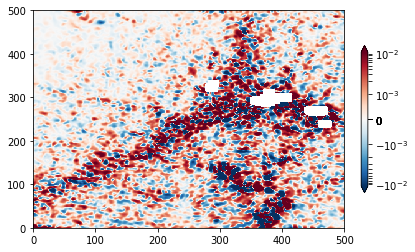

In [132]:
# just to check the results

imod = 1
toplot = gaussian_filter(dissmod[imod,:,:], sigma=siglur)
plt.figure()
plt.pcolormesh(toplot, cmap="RdBu_r", norm=norm)
ax.set_aspect(1)
plt.colorbar(fraction=.02, extend="both")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


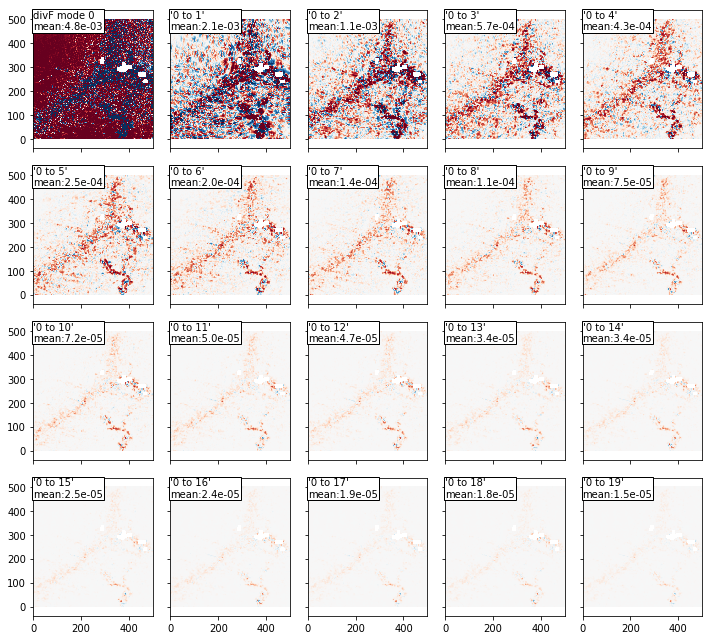

In [73]:
### plot conversion terms (take AVG) and mode divergence
# n-to-anymode with divF instead of n-to-n

imod = 0 # 0 will be barotropic conversion, other will be scattering
doblur = True
sigblur = 3

#vamp = 10*np.nanstd(czon[0,:,:])
norm = colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
                         
fig, axs = plt.subplots(4, (nmod+1)//4, sharex=True, sharey=True, figsize=(2*(nmod+1)//4, 4.5*2))
for ia,ax in enumerate(axs.ravel()):
    if ia == imod: 
        toplot = np.ma.masked_where(mast,divfmod[imod,:,:])
        ax.text(0, 1, "divF mode {0:d} \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    else:
        nc = Dataset(filout, "r")
        if ia>imod:
            toplot = np.ma.masked_where(mast,nc.variables['Cmn'][imod,ia,:,:])
        else:
            toplot = -np.ma.masked_where(mast,nc.variables['Cmn'][ia,imod,:,:])
        ax.text(0, 1, "'{0:d} to {1:d}' \nmean:{2:.1e}".format(imod,ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    if doblur:
        toplot = gaussian_filter(toplot, sigma=siglur)
    ax.pcolormesh(toplot, norm=norm, cmap="RdBu_r")
    ax.set_aspect(1)
    
fig.set_tight_layout(True)

## Old stuff (plots and comparison with linear prediction)

now doing mode 1


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


now doing mode 2
now doing mode 3
now doing mode 4
now doing mode 5
now doing mode 6
now doing mode 7
now doing mode 8
now doing mode 9


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


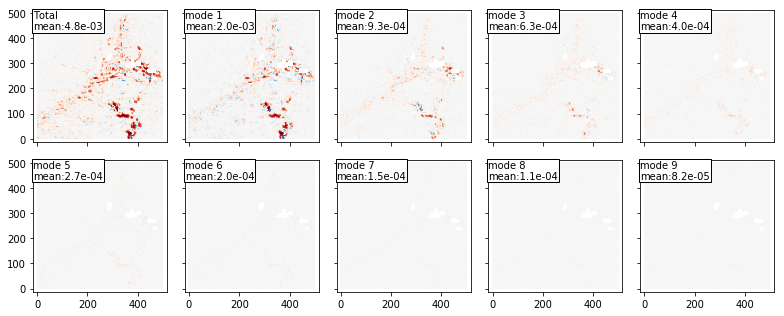

In [9]:
# compute conversion terms (should be in W/m²) barotropic -> mode n
# compute conversion term (no filtering) and lowpass filter / average
# N.B.: this is covered by conversion matrix Cmn

# plot flux divegence (take AVG)
#doblur = True
#siglur = 2
#indt = np.arange(600,687) # 5 days or 87 (7 tidal periods) seems fair, but it does vary
indm = range(1,nmod)

# set up filter
dt = 1
bb, aa = sig.butter(4, 2*dt/30)
# m=0, n
nc = Dataset(data_mod, "r")
umod = nc.variables['u_amp']
vmod = nc.variables['v_amp']
pmod = nc.variables['p_amp']

zrho = nc.variables['zrb']

czon = np.full((len(indm),ny,nx),np.nan) # this is the conversion term
test = np.full((len(indm),len(indt)),np.nan)

phim = nc.variables['p_modes'][0,0,...]
lam = 1./nc.variables["mode_speed"][0,...]**2
for imod in indm:
    lan = 1./nc.variables["mode_speed"][imod,...]**2
    phin = nc.variables['p_modes'][imod,0,...]
    print("now doing mode",imod,flush=True)
    prov = phim*phin / (lam-lan) * (\
                        pmod[indt,0,...]*lam*(umod[indt,imod,...]*dhdx + vmod[indt,imod,...]*dhdy) + \
                        pmod[indt,imod,...]*lan*(umod[indt,0,...]*dhdx + vmod[indt,0,...]*dhdy) )
    indy,indx = np.where(np.isfinite(prov[0,...]))
    czon[imod-1,indy,indx] = sig.filtfilt(bb, aa, prov[:,indy,indx], method="gust", axis=0).mean(axis=0)*rho0
    test[imod-1,:] = prov[:,200,200]
nc.close()

# plot conversion terms (take AVG)
nc = Dataset(data_nrj,'r')

nc.close()

vamp = 10*np.nanstd(czon[0,:,:])
norm = colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
                         
fig, axs = plt.subplots(2, (nmod+1)//2, sharex=True, sharey=True, figsize=(2*(nmod+1)//2, 4.5))
for ia,ax in enumerate(axs.ravel()):
    if ia==0: 
        toplot = np.ma.masked_where(mast,czon.sum(axis=0))
    else:
        toplot = np.ma.masked_where(mast,czon[ia-1,:,:])
    if doblur:
        toplot = gaussian_filter(toplot, sigma=siglur)
    ax.pcolormesh(toplot, norm=norm, cmap="RdBu_r")
    if ia == 0:
        ax.text(0, 1, "Total \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    else:    
        ax.text(0, 1, "mode {0} \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    ax.set_aspect(1)
    
fig.set_tight_layout(True)

In [67]:
# compute conversion terms (should be in W/m²) baroclinic -> mode n
# compute conversion term (no filtering) and lowpass filter / average

indm = range(nmod)

# set up filter
dt = 1
bb, aa = sig.butter(4, 2*dt/30)
# m=0, n
nc = Dataset(data_mod, "r")
umod = nc.variables['u_amp']
vmod = nc.variables['v_amp']
pmod = nc.variables['p_amp']

zrho = nc.variables['zrb']

czmn = np.full((len(indm),ny,nx),np.nan)
test = np.full((len(indm),len(indt)),np.nan)

for imod in indm:
    print("now doing mode",imod,flush=True)
    phim = nc.variables['p_modes'][imod,0,...]
    lam = 1./nc.variables["mode_speed"][imod,...]**2
    prov = np.zeros((ny,nx))
    for inod in indm:
        if inod==imod: continue
        lan = 1./nc.variables["mode_speed"][inod,...]**2
        phin = nc.variables['p_modes'][inod,0,...]
        prav = phim*phin / (lam-lan) * (\
                            pmod[indt,imod,...]*lam*(umod[indt,inod,...]*dhdx + vmod[indt,inod,...]*dhdy) + \
                            pmod[indt,inod,...]*lan*(umod[indt,imod,...]*dhdx + vmod[indt,imod,...]*dhdy) )
        indy,indx = np.where(np.isfinite(prav[0,...]))
        prov[indy,indx] += sig.filtfilt(bb, aa, prav[:,indy,indx], method="gust", axis=0).mean(axis=0)*rho0
    czmn[imod-1,:,:] = prov
nc.close()

now doing mode 0


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


now doing mode 1
now doing mode 2
now doing mode 3
now doing mode 4
now doing mode 5
now doing mode 6
now doing mode 7
now doing mode 8
now doing mode 9


KeyboardInterrupt: 

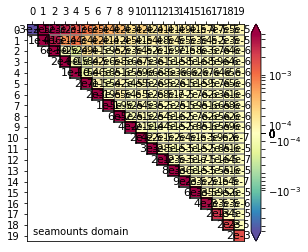

In [19]:
vamp = 5e-3
fs = 10
gcol = "grey"
glw = 1.5
do = "seamounts"
cmap = "Spectral_r"

fig, axs = plt.subplots(1,1)
ax = axs#[0]
toplot = ctmn[do] + np.diag(divfmoy[do])
him = ax.imshow(np.ma.masked_where(toplot==0,toplot),cmap=cmap,norm=colors.SymLogNorm(linthresh=vamp/10, vmin=-vamp, vmax=vamp))
plt.colorbar(him, fraction=.03, extend="both", pad=.02)

# add values
for jj in indm:
    for ii in indm[jj+1:]:
        ax.text(ii, jj, eformat(toplot[jj,ii]), ha="center", va="center", fontsize=fs)
    ax.text(jj, jj, eformat(toplot[jj,jj]), ha="center", va="center", fontsize=fs+1)

ax.set_xticks(np.arange(nmod))
ax.set_yticks(np.arange(nmod))
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
for jj in range(nmod-1): # add special grid
    ax.plot([jj+1.5,nmod-.5], [jj+.5,jj+.5], color=gcol, lw=glw)
    ax.plot([jj+.5,jj+.5], [-.5,jj-.5], color=gcol, lw=glw-.5)
    ax.plot([jj-.5,jj+1.5], [jj+.5,jj+.5], color="k", lw=glw)
    ax.plot([jj+.5,jj+.5], [jj-.5,jj+1.5], color="k", lw=glw)

ax.text(.03, .03, do+" domain", transform=ax.transAxes)

if dosavefig:
    fig.savefig("pictures/slides/Cmn_mat_{}.pdf".format(do), magnification="auto", bbox_inches="tight")

if False:    
    # every subdomains
    fix, axs = plt.subplots(3,2, figsize=(8,12))
    for ia,nam in enumerate(nams):
        ax = axs.ravel()[ia]#[0]
        toplot = ctmn[nam] + np.diag(divfmoy[nam])
        him = ax.imshow(np.ma.masked_where(toplot==0,toplot), cmap="RdBu_r", 
                        norm=colors.SymLogNorm(linthresh=vamp/10, vmin=-vamp, vmax=vamp))
        #for jj in indm:
        #    for ii in indm[jj+1:]:
        #        ax.text(ii, jj, eformat(toplot[jj,ii]), ha="center", va="center", fontsize=fs)
        #    ax.text(jj, jj, eformat(toplot[jj,jj]), ha="center", va="center", fontsize=fs+1)
        ax.text(0, nmod-1, nam)

cbtrop 0.00512486956408
cbclin 8.13151629364e-20
ctot 0.00512486956408
divf 0.0011356
diss 0.00398926757093


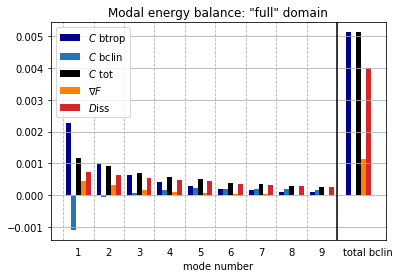

In [17]:
do = "full" # 'islands', 'ridge2', 'ridge1', 'ridge3', 'seamounts', 'full', 'ridge4'

fields = ["cbtrop","cbclin","ctot","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black",'tab:orange','tab:red']

width = .8

prov = ctmn[do] - ctmn[do].T
cbclin = prov[1:,1:].sum(axis=0)
cbtrop = ctmn[do][0,1:]
ctot = cbclin+cbtrop
divf = divfmoy[do][1:]
diss = ctot-divf

fig = plt.figure()
ax = plt.subplot(111)
for imod in range(1,nmod):
    for ifi,fie in enumerate(fields):
        lab = labs[ifi] if imod==1 else None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
               color=cols[ifi], label=lab)

ax.axvline(imod+.5, color="k")
imod += 1.2
for ifi,fie in enumerate(fields):
    lab = None
    ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie).sum(), width/len(fields), 
           color=cols[ifi], label=lab)
    print(fie,eval(fie).sum())
    
#ax.set_xticks(ind)
#ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")
plt.grid(True)
ax.set_xticks(np.r_[np.arange(1,nmod),nmod+.5])
ax.set_xticklabels([str(ii) for ii in range(1,nmod)]+["total bclin"])
ax.grid(which="major", axis="x", linestyle="none")
ax.set_xticks(.5+np.arange(nmod), minor=True)
ax.grid(which="minor", axis="x", linestyle="--")
ax.tick_params(bottom=False, which="both")
plt.legend()
#plt.title(simul.upper()+": NRJ balance per subdomain")
plt.title('Modal energy balance: "{}" domain'.format(do))
ax.set_xlabel("mode number")
    
if False:
    fig.savefig("pictures/slides/{0}_ModBal_{1}.pdf".format(simul,do), magnification="auto", bbox_inches="tight")



cbtrop 5.29780218401
cbclin -6.24500451352e-17
ctot 5.29780218401
divf 1.25016
diss 4.04763802917
cbtrop 37.5469362423
cbclin 6.52256026967e-16
ctot 37.5469362423
divf 22.0224
diss 15.5245731049
cbtrop 18.8468236995
cbclin -3.33066907388e-16
ctot 18.8468236995
divf 1.23469
diss 17.6121363713
cbtrop 6.73750081223
cbclin 3.33066907388e-16
ctot 6.73750081223
divf 0.302787
diss 6.43471370249
cbtrop 10.3264477411
cbclin 3.05311331772e-16
ctot 10.3264477411
divf -0.399966
diss 10.7264138005
cbtrop 12.1138762462
cbclin 6.52256026967e-16
ctot 12.1138762462
divf 0.609669
diss 11.5042069482
cbtrop 7.08163235527
cbclin -1.11022302463e-16
ctot 7.08163235527
divf 1.89157
diss 5.19006268847


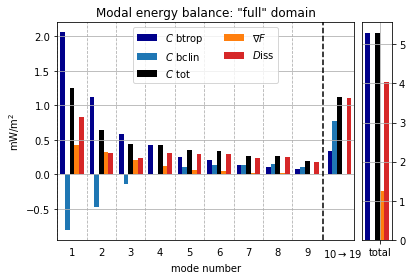

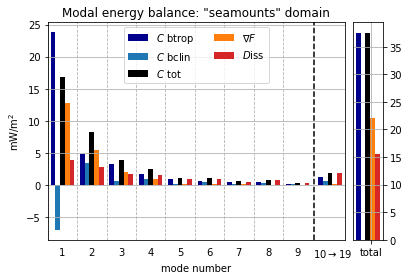

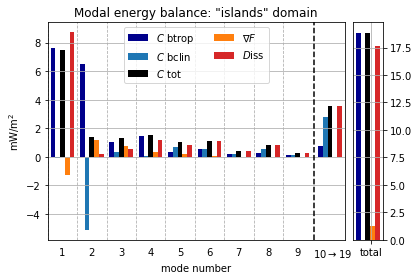

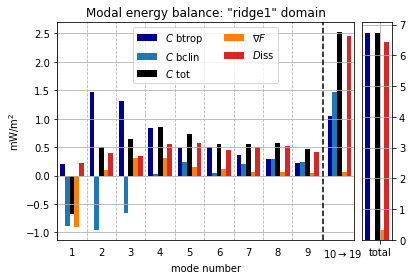

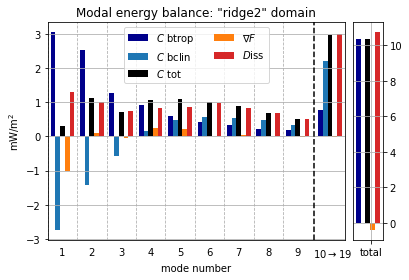

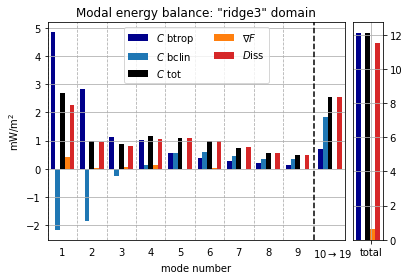

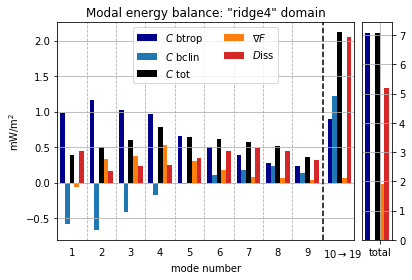

In [134]:
# paper purpose: no linear theory but add sum 10 to 19 and put total with distinct y-axis

do = "full" # 'islands', 'ridge2', 'ridge1', 'ridge3', 'seamounts', 'full', 'ridge4'

fields = ["cbtrop","cbclin","ctot","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black",'tab:orange','tab:red']

width = .8
nmod = 9
nmax= 19

for do in ['full']+nams:
    prov = ctmn[do] - ctmn[do].T
    cbclin = prov[1:,1:].sum(axis=0)*1e3
    cbtrop = ctmn[do][0,1:]*1e3
    ctot = cbclin+cbtrop
    divf = divfmoy[do][1:]*1e3
    diss = ctot-divf

    fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios":[nmod+1,1]})
    ax = axs[0]
    for imod in range(nmod):
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if imod==0 else None
            ax.bar(imod+1-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod], width/len(fields), 
                   color=cols[ifi], label=lab)

    ax.axvline(imod+1.55, color="k", linestyle="--")
    imod += 1.1
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(imod+1-width/2+width*(ifi+.5)/len(fields), eval(fie)[nmod:nmax].sum(), width/len(fields), 
               color=cols[ifi], label=lab)
        print(fie,eval(fie).sum())

    #ax.set_xticks(ind)
    #ax.set_xticklabels(nams+['Total'], rotation=27, y=.03, ha="center")
    ax.grid(True)
    ax.set_xticks(np.r_[np.arange(1,nmod+1),nmod+1.2])
    ax.set_xticklabels([str(ii) for ii in range(1,nmod+1)]+[str(nmod+1)+r"$\rightarrow$"+str(nmax)])
    ax.grid(which="major", axis="x", linestyle="none")
    ax.set_xticks(.5+np.arange(nmod), minor=True)
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    ax.legend(ncol=2, loc="upper center")
    ax.set_title('Modal energy balance: "{}" domain'.format(do))
    ax.set_xlabel("mode number")
    ax.set_xlim([.5, nmod+1.6])  
    ax.set_ylabel(r"mW/m$^2$")

    ax = axs[1]
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(width*(ifi+.5)/len(fields), eval(fie).sum(), width/len(fields), 
               color=cols[ifi], label=lab)

    ax.set_xticks([.5])
    ax.set_xticklabels(['total'])
    ax.yaxis.tick_right()
    ax.set_xlim([-.1,.9])
    ax.grid(True)

    fig.subplots_adjust(wspace=.05)

    if dosavefig:
        fig.savefig("pictures/paper"+'ModalNRJbalance_{0}_n{1}o{2}.pdf'.format(do,str(nmod),str(nmax)), 
                        magnification='auto', bbox_inches="tight")

## Comparison with linear prediction (Falahat et al 2014 and personal computation)

In [28]:
# first load

# routine to load Falahat et al 2014 btrop-> modal estimate
def get_Fa14_interp(filepath, lon_h=lon, lat_h=lat, doitp=True, kitp=3):
    """ Load data file for barotropic modal convesion from Falahat et al 2014
    dowloaded from https://doi.org/10.17882/58153
    hard coded: number of modes (1 to 5, then sum 6 to 10)
    Returns conv_term, topo if dointerp is True. Otherwise conv_term, mask """
    
    lonmin, lonmax = lon_h.min(), lon_h.max()
    latmin, latmax = lat_h.min(), lat_h.max()
    nlon, nlat = lon_h.shape[-1], lat_h.shape[0]

    # load fields and interpolate on given points at the same time
    # first five modes and sum of modes 6 to 10
    nc = Dataset(filepath, "r")

    lon_f = nc.variables['lon'][:]
    indx, = np.where((lon_f>=lonmin) & (lon_f<=lonmax))
    i1, i2 = indx[0], indx[-1]
    lon_f = lon_f[i1:i2]
    lat_f = nc.variables['lat'][:]
    indy, = np.where((lat_f>=latmin) & (lat_f<=latmax))
    j1, j2 = indy[0], indy[-1]
    lat_f = lat_f[j1:j2]
    h_f = nc.variables['seafloor_depth'][j1:j2,:][:,i1:i2]

    if doitp:
        cnf = np.zeros((5+1,nlon,nlat))
        prov = nc.variables['power_modes6to10'][j1:j2,:][:,i1:i2]
        masf = ~np.isnan(prov)
        prov = np.where(masf, prov, 0)
        prov = itp.RectBivariateSpline(lon_f, lat_f, prov.T, kx=kitp, ky=kitp)
        for ilat in range(nlat):
            cnf[5,:,ilat] = prov.ev(lon_h[:,ilat], lat_h[:,ilat])
        for imod in range(5):
            prov = np.where(masf, nc.variables['power_mode{}'.format(imod+1)][j1:j2,:][:,i1:i2], 0)
            prov = itp.RectBivariateSpline(lon_f, lat_f, prov.T, kx=kitp, ky=kitp)
            for ilat in range(nlat):
                cnf[imod,:,ilat] = prov.ev(lon_h[:,ilat], lat_h[:,ilat])

        prov = itp.RectBivariateSpline(lon_f, lat_f, h_f.T, kx=kitp, ky=kitp)
        h_f = np.zeros((nlat, nlon))
        for ilat in range(nlat):
            h_f[:,ilat] = prov.ev(lon_h[:,ilat], lat_h[:,ilat])
        masf = h_f
    else:

        cnf = np.zeros((5+1,j2-j1,i2-i1))
        for imod in range(5):
            cnf[imod,:,:] = nc.variables['power_mode{}'.format(imod+1)][j1:j2,:][:,i1:i2]
        cnf[imod+1,:,:] = nc.variables['power_modes6to10'][j1:j2,:][:,i1:i2]    
        masf = ~np.isnan(cnf[0,:,:])

    nc.close()
    return cnf, masf

prov, masf = get_Fa14_interp(data_Fa14)
masf = (masf > 400)
imof = np.shape(prov)[0]
   
cnfa14 = {nam:get_domean(prov, dom, masksup=masf) for nam,dom in zip(nams,doms)}
cnfa14["full"] = prov[:,masf].mean(axis=-1)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


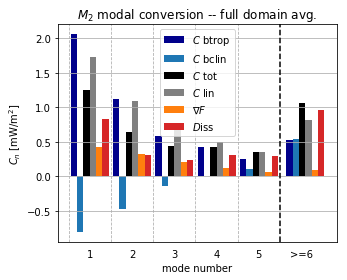

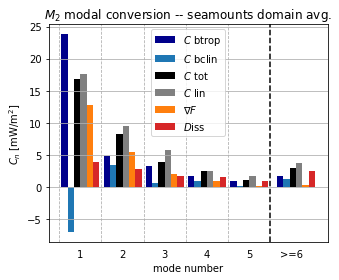

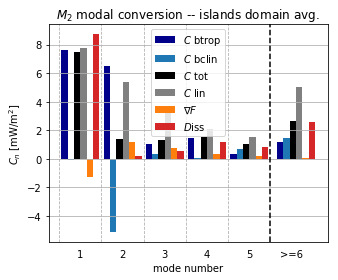

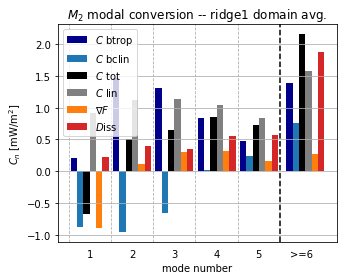

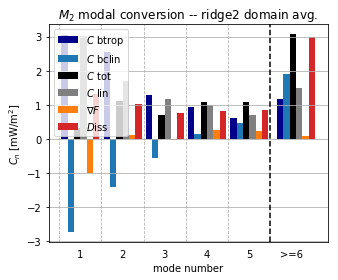

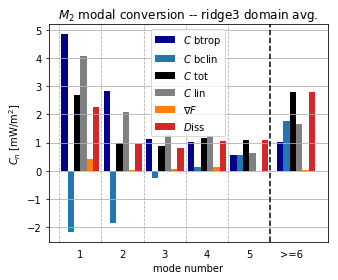

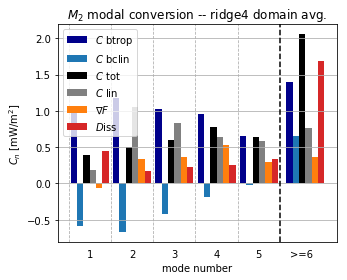

In [68]:
### compare against Falahat & Nycander
### bar plot of mean modal conversion
do = "ridge2" 

#cmean = np.r_[[ctn[ii,:,:][mask].mean() for ii in range(ctn.shape[0])]] * 1e3

fields = ["cbtrop","cbclin","ctot","cnf","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot","$C$ lin",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black","grey",'tab:orange','tab:red']

nmod = imof - 1
nmax = 9
width = .9

def tofamod(tab, nmod=nmod, nmax=nmax):
    if len(tab)<nmax:
        nmax=len(tab)+1
    return np.r_[tab[:nmod], tab[nmod:nmax].sum()]

for do in ['full']+nams:
    prov = ctmn[do] - ctmn[do].T
    cbclin = tofamod(prov[1:,1:].sum(axis=0))*1e3
    cbtrop = tofamod( ctmn[do][0,1:] )*1e3
    ctot = tofamod( cbclin+cbtrop )
    divf = tofamod( divfmoy[do][1:] )*1e3
    diss = ctot-divf
    cnf = cnfa14[do]*1e3

    fig = plt.figure(figsize=(5,4))
    ax = plt.subplot(111)
    for imod in range(1,nmod+1):
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if imod==1 else None
            ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
                   color=cols[ifi], label=lab)

    ax.axvline(imod+.5, color="k", linestyle="--")
    imod += 1
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields)+.1, eval(fie)[imod-1], width/len(fields), 
               color=cols[ifi], label=lab)

    ax.grid(True)
    ax.set_xticks(np.r_[np.arange(1,nmod+1),nmod+1])
    ax.set_xticklabels([str(ii) for ii in range(1,nmod+1)]+[">={}".format(nmod+1)])
    ax.grid(which="major", axis="x", linestyle="none")
    ax.set_xticks(.5+np.arange(nmod), minor=True)
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    plt.legend()
    ax.set_xlabel("mode number")
    ax.set_ylabel(r"$C_n$ [mW/m$^2$]")
    ax.set_title(r'$M_2$ modal conversion -- {} domain avg.'.format(do))
    
    if dosavefig:
        fig.savefig(dirpic+'ModalBalance_NumVsFa14_{0}_nmod{1}o{2}.pdf'.format(do,str(nmod),str(nmax)), 
                    magnification='auto', bbox_inches="tight")

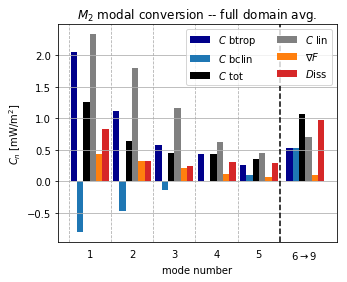

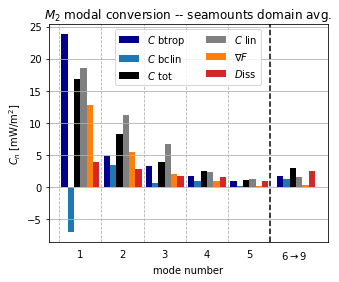

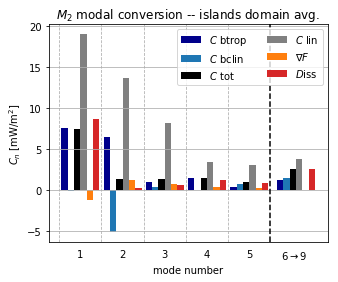

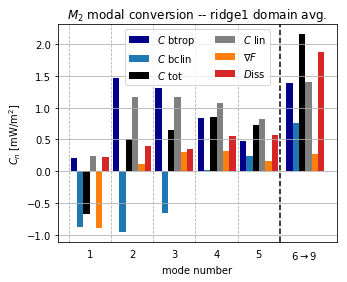

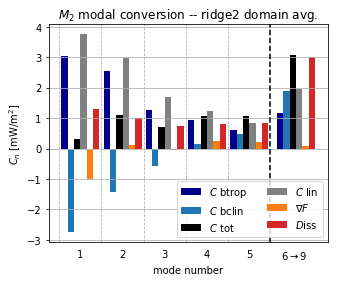

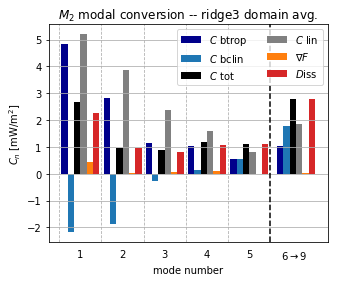

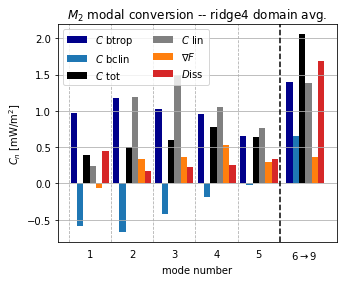

In [71]:
### compare against my computation

# load result from calculation
ncgrd = Dataset(grid_file,'r')
masl = ncgrd.variables['h'][:]>300
ncgrd.close()

nc = Dataset(KRYPTON+"Tide_Conv/output_data/ModalConv_LinCalc_lucky_M2_20modes.nc", "r")
lon_lin = nc.variables['lon'][:]
lat_lin = nc.variables['lat'][:]
ctvar = nc.variables['Ctn']

nmod = 5
nmax = 9

ctnli = {nam:np.array([get_domean(ctvar[imod,...], dom, lon=lon_lin, lat=lat_lin, masksup=masl) 
                       for imod in range(nmax)]) for nam,dom in zip(nams,doms)}
ctnli["full"] = ctvar[:][:,masl].mean(axis=-1)
nc.close()

### bar plot of mean modal conversion
do = "full" 

#cmean = np.r_[[ctn[ii,:,:][mask].mean() for ii in range(ctn.shape[0])]] * 1e3

fields = ["cbtrop","cbclin","ctot","ctlin","divf","diss"]
labs = [r"$C$ btrop", r"$C$ bclin",r"$C$ tot","$C$ lin",r"$\nabla F$",r"$D$iss"]
cols = ["darkblue",'tab:blue',"black","grey",'tab:orange','tab:red']

width = .9

def tofamod(tab, nmod=nmod, nmax=nmax):
    if len(tab)<nmax:
        nmax=len(tab)+1
    return np.r_[tab[:nmod], tab[nmod:nmax].sum()]

for do in ["full"]+nams:
    prov = ctmn[do] - ctmn[do].T
    cbclin = tofamod(prov[1:,1:].sum(axis=0), nmod, nmax)*1e3
    cbtrop = tofamod(ctmn[do][0,1:], nmod, nmax)*1e3
    ctot = tofamod(cbclin+cbtrop, nmod, nmax)
    divf = tofamod(divfmoy[do][1:], nmod, nmax)*1e3
    diss = ctot-divf
    ctlin = tofamod(ctnli[do], nmod, nmax)*1e3

    fig = plt.figure(figsize=(5,4))
    ax = plt.subplot(111)
    for imod in range(1,nmod+1):
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if imod==1 else None
            ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
                   color=cols[ifi], label=lab)

    ax.axvline(imod+.5, color="k", linestyle="--")
    imod += 1
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields)+.1, eval(fie)[imod-1], width/len(fields), 
               color=cols[ifi], label=lab)

    ax.grid(True)
    ax.set_xticks(np.r_[np.arange(1,nmod+1),nmod+1])
    ax.set_xticklabels([str(ii) for ii in range(1,nmod+1)]+["  "+str(nmod+1)+r"$\rightarrow$"+str(nmax)])
    ax.grid(which="major", axis="x", linestyle="none")
    ax.set_xticks(.5+np.arange(nmod), minor=True)
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    plt.legend(ncol=2)
    ax.set_xlabel("mode number")
    ax.set_ylabel(r"$C_n$ [mW/m$^2$]")
    ax.set_title(r'$M_2$ modal conversion -- {} domain avg.'.format(do))

    if dosavefig:
        fig.savefig(dirpic+'ModalBalance_NumVsLin_{0}_nmod{1}o{2}.pdf'.format(do,str(nmod),str(nmax)), 
                    magnification='auto', bbox_inches="tight")

In [ ]:
### paper purpose: remove linear theory but add total

Compare modal generation: linear, falahat, model

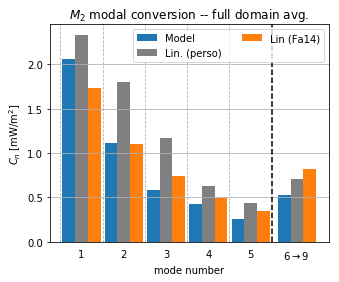

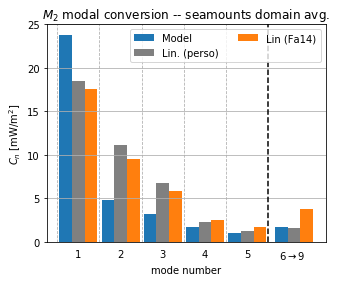

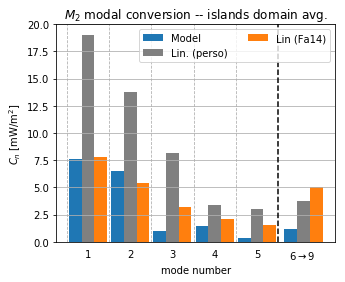

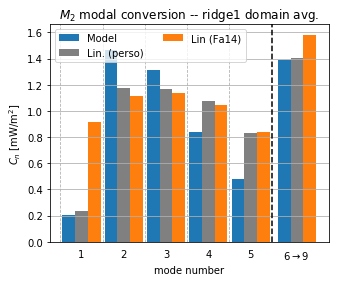

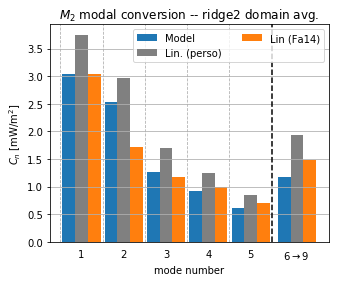

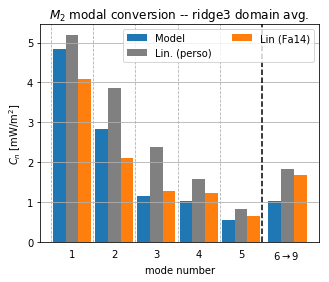

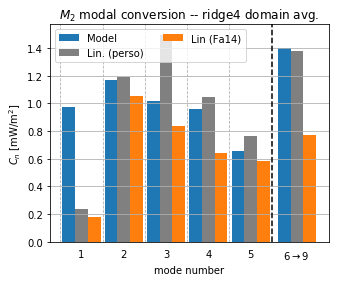

In [77]:
### compare against my computation


fields = ["cbtrop","ctlin","cnf"]
labs = [r"Model", r"Lin. (perso)",r"Lin (Fa14)"]
cols = ['tab:blue',"grey",'tab:orange']

width = .9

def tofamod(tab, nmod=nmod, nmax=nmax):
    if len(tab)<nmax:
        nmax=len(tab)+1
    return np.r_[tab[:nmod], tab[nmod:nmax].sum()]

for do in ["full"]+nams:
    cbtrop = tofamod(ctmn[do][0,1:], nmod, nmax)*1e3
    ctlin = tofamod(ctnli[do], nmod, nmax)*1e3
    cnf = cnfa14[do]*1e3

    fig = plt.figure(figsize=(5,4))
    ax = plt.subplot(111)
    for imod in range(1,nmod+1):
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if imod==1 else None
            ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
                   color=cols[ifi], label=lab)

    ax.axvline(imod+.5, color="k", linestyle="--")
    imod += 1
    for ifi,fie in enumerate(fields):
        lab = None
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields)+.1, eval(fie)[imod-1], width/len(fields), 
               color=cols[ifi], label=lab)

    ax.grid(True)
    ax.set_xticks(np.r_[np.arange(1,nmod+1),nmod+1])
    ax.set_xticklabels([str(ii) for ii in range(1,nmod+1)]+["  "+str(nmod+1)+r"$\rightarrow$"+str(nmax)])
    ax.grid(which="major", axis="x", linestyle="none")
    ax.set_xticks(.5+np.arange(nmod), minor=True)
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    plt.legend(ncol=2)
    ax.set_xlabel("mode number")
    ax.set_ylabel(r"$C_n$ [mW/m$^2$]")
    ax.set_title(r'$M_2$ modal conversion -- {} domain avg.'.format(do))

    if dosavefig:
        fig.savefig('pictures/comp_linFa14_model/ModalBalance_NumVsLin_CompMethods_{}.pdf'.format(do), magnification='auto', bbox_inches="tight")

## Modal conversion, bar plot: model vs. linear

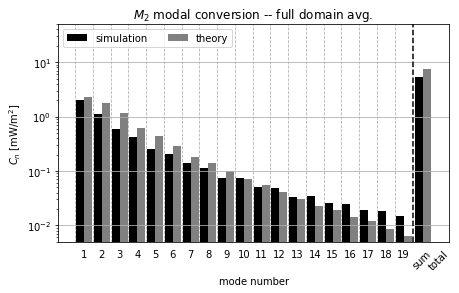

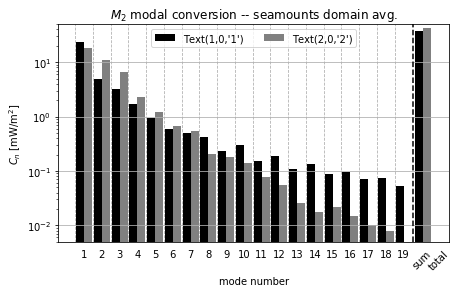

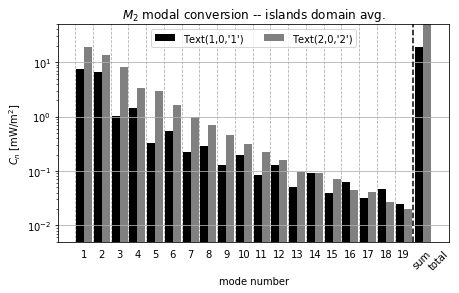

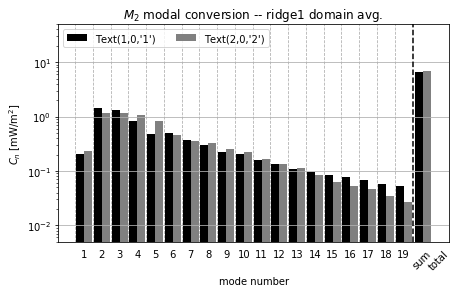

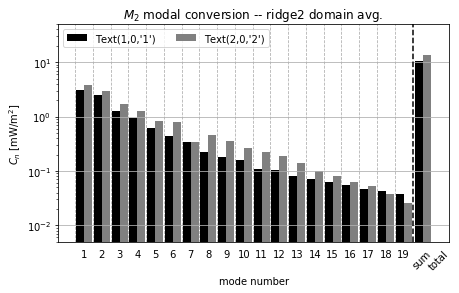

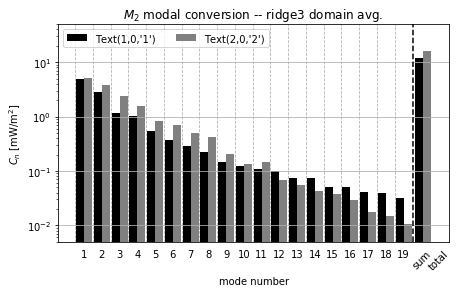

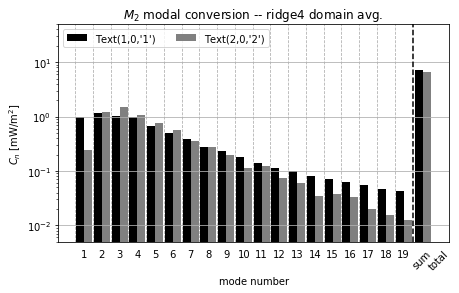

In [96]:
### compare against my computation
ncgrd = Dataset(grid_file,'r')
masl = ncgrd.variables['h'][:]>300
ncgrd.close()

nc = Dataset(KRYPTON+"Tide_Conv/output_data/ModalConv_LinCalc_lucky_M2_20modes.nc", "r")
lon_lin = nc.variables['lon'][:]
lat_lin = nc.variables['lat'][:]
ctvar = nc.variables['Ctn']

nmod = 19
nmax = 19

ctnli = {nam:np.array([get_domean(ctvar[imod,...], dom, lon=lon_lin, lat=lat_lin, masksup=masl) 
                       for imod in range(nmax)]) for nam,dom in zip(nams,doms)}
ctnli["full"] = ctvar[:][:,masl].mean(axis=-1)
nc.close()
# execute previous cells before

fields = ["cbtrop","ctlin"]
labs = [r"simulation", r"theory"]
cols = ['black',"grey"]
uselog = True
limy = [5e-3, 5e1]

width = .9

def tofamod(tab, nmod=nmod, nmax=nmax):
    if len(tab)<nmax:
        nmax=len(tab)+1
    return np.r_[tab[:nmod], tab[nmod:nmax].sum()]

ticklab = [str(ii) for ii in range(1,nmod+1)]

for do in ["full"]+nams:
    cbtrop = tofamod(ctmn[do][0,1:], nmod, nmax)*1e3
    ctlin = tofamod(ctnli[do], nmod, nmax)*1e3

    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot(111)
    for imod in range(1,nmod+1):
        for ifi,fie in enumerate(fields):
            lab = labs[ifi] if imod==1 else None
            ax.bar(imod-width/2+width*(ifi+.5)/len(fields), eval(fie)[imod-1], width/len(fields), 
                   color=cols[ifi], label=lab, log=uselog)
    
    if nmod < nmax:
        ax.axvline(imod+.5, color="k", linestyle="--")
        imod += 1
        for ifi,fie in enumerate(fields):
            lab = None
            ax.bar(imod-width/2+width*(ifi+.5)/len(fields)+.1, eval(fie)[imod-1], width/len(fields), 
                   color=cols[ifi], label=lab, log=uselog)

        ax.set_xticks(np.arange(1,nmod+4))
        ticklab += ["  "+str(nmod+1)+r"$\rightarrow$"+str(nmax)]
    else:
        ax.set_xticks(np.arange(1,nmod+3))
    ax.axvline(imod+.5, color="k", linestyle="--")
    imod += 1
    for ifi, fie in enumerate(fields):
        ax.bar(imod-width/2+width*(ifi+.5)/len(fields)+.1, eval(fie)[:nmax].sum(), width/len(fields), 
                   color=cols[ifi], label=lab, log=uselog)
    ticklab += ['sum', 'total']
    labs = ax.set_xticklabels(ticklab)
    for lab in labs[-2:]: lab.set_rotation(45)
        
    ax.grid(True)
    ax.grid(which="major", axis="x", linestyle="none")
    ax.set_xticks(.5+np.arange(nmod), minor=True)
    ax.grid(which="minor", axis="x", linestyle="--")
    ax.tick_params(bottom=False, which="both")
    plt.legend(ncol=2)
    ax.set_xlabel("mode number")
    ax.set_ylabel(r"$C_n$ [mW/m$^2$]")
    ax.set_title(r'$M_2$ modal conversion -- {} domain avg.'.format(do))
    ax.set_ylim(limy)
    
    if dosavefig:
        fig.savefig(dirpic+'ModalConv_NumVsLin_{0}_n{1}o{2}.pdf'.format(do,str(nmod),str(nmax)), 
                    magnification='auto', bbox_inches="tight")

# Old stuff

In [92]:
dir(labs[-1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_axes',
 '_bbox_patch',
 '_cached',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_draw_bbox',
 '_fontproperties',
 '_get_dist_to_box',
 '_get_layout',
 '_get_multialignment',
 '_get_rendered_text_width',
 '_get_wrap_line_width',
 '_get_wrapped_text',
 '_get_xy_display',
 '_gid',
 '_horizontalalignment',
 '_label',
 '_linespacing',
 '_mouseover',
 '_multialignment',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_renderer',
 '_rotation',
 '_rotation_mode',
 '_set_gc_clip',
 '_sketch',
 '_snap',
 '_stale',
 '_sticky_

now doing mode 1


/home/lahaye/Coding/virtual_envs/py3libra/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3libra/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3libra/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3libra/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3libra/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


now doing mode 2
now doing mode 3
now doing mode 4
now doing mode 5
now doing mode 6
now doing mode 7
now doing mode 8
now doing mode 9


<IPython.core.display.Javascript object>


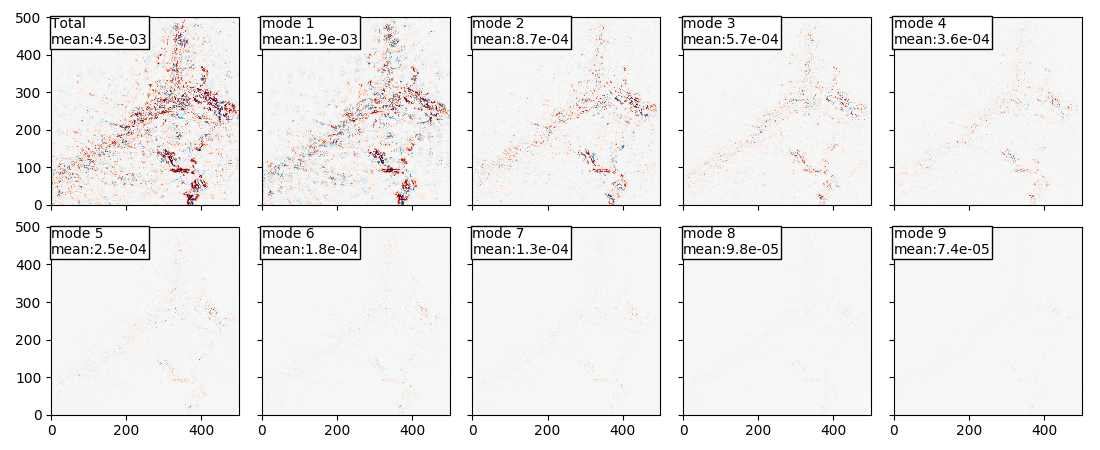

In [148]:
# try compute the rigid lid version (barotropic -> mode n conversion term)
czon = np.zeros((nmod-1,ny,nx))
indt = np.arange(nt-87,nt) # 87 (7 tidal periods) seems fair, but it does vary
indm = range(1,nmod)

# set up filter
dt = 1
bb, aa = sig.butter(4, 2*dt/30)
# m=0, n
nc = Dataset(data_mod, "r")
umod = nc.variables['u_amp']
vmod = nc.variables['v_amp']
pmod = nc.variables['p_amp']

zrho = nc.variables['zrb']

czob = np.full((len(indm),ny,nx),np.nan)
test = np.zeros((len(indm),len(indt)))

phim = nc.variables['p_modes'][0,0,...]
lam = 1./nc.variables["mode_speed"][0,...]**2
for imod in indm:
    lan = 1./nc.variables["mode_speed"][imod,...]**2
    phin = nc.variables['p_modes'][imod,0,...]
    print("now doing mode",imod,flush=True)
    prov = - (dhdx*umod[indt,0,:,:] + dhdy*vmod[indt,0,:,:]) * pmod[indt,imod,:,:]*phin
    indy,indx = np.where(np.isfinite(prov[0,...]))
    czob[imod-1,indy,indx] = sig.filtfilt(bb, aa, prov[:,indy,indx], method="gust", axis=0).mean(axis=0)*1e3
    test[imod-1,:] = prov[:,200,200]
nc.close()

# plot it
#vamp = 10*np.nanstd(czob[0,:,:])
norm = colors.SymLogNorm(linthresh=vamp/10, linscale=1, vmin=-vamp, vmax=vamp)
                         
fig, axs = plt.subplots(2, (nmod+1)//2, sharex=True, sharey=True, figsize=(2*(nmod+1)//2, 4.5))
for ia,ax in enumerate(axs.ravel()):
    if ia==0: 
        toplot = np.ma.masked_where(mast,czob.sum(axis=0))
    else:
        toplot = np.ma.masked_where(mast,czob[ia-1,:,:])
    ax.pcolormesh(toplot, norm=norm, cmap="RdBu_r")
    if ia == 0:
        ax.text(0, 1, "Total \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    else:    
        ax.text(0, 1, "mode {0} \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', 
            transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    ax.set_aspect(1)
    
fig.set_tight_layout(True)

<IPython.core.display.Javascript object>


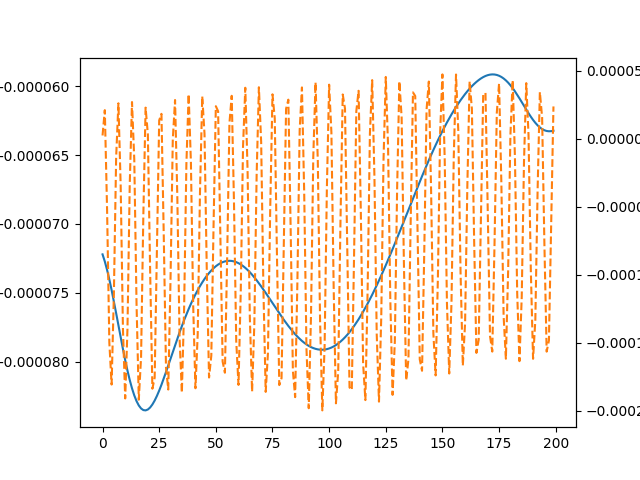

In [126]:
# evolution of convesion term (barotropic -> mode n), unfiltered and filtered (this would not work with current version)
# ça à l'air de bouger pendant le run... 
plt.figure()
ax = plt.gca()
ax.plot(czon[:,50,50])
bx = ax.twinx()
bx.plot(prov[:,50,50],color="tab:orange", linestyle="--")

<IPython.core.display.Javascript object>


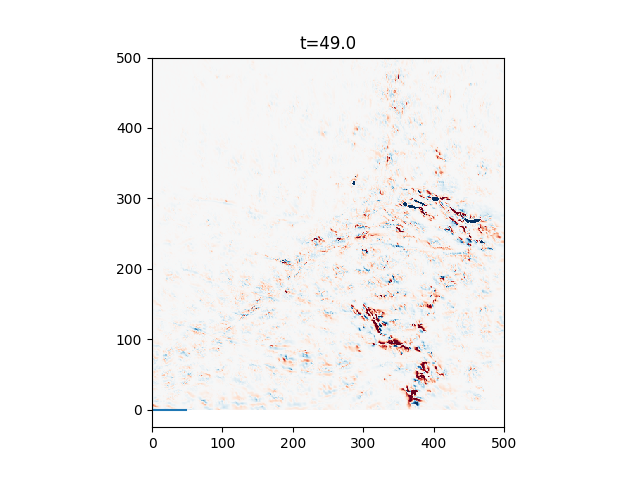

In [101]:
# animate map of conversion terms (see tidal periodicity)
fig = plt.figure()
ax = plt.gca()
hpc = plt.pcolormesh(czon[0,:,:]*1e3, vmin=-.5, vmax=.5, cmap="RdBu_r")
ax.set_title("t={:.1f}".format(times[0]))
ax.set_aspect(1)

def fanim(it):
    hpc.set_array(czon[it,:,:].ravel()*1e3)
    ax.set_title("t={:.1f}".format(times[it]))

ani = FuncAnimation(fig, fanim, frames=len(indt), interval=100, repeat=False)

<IPython.core.display.Javascript object>


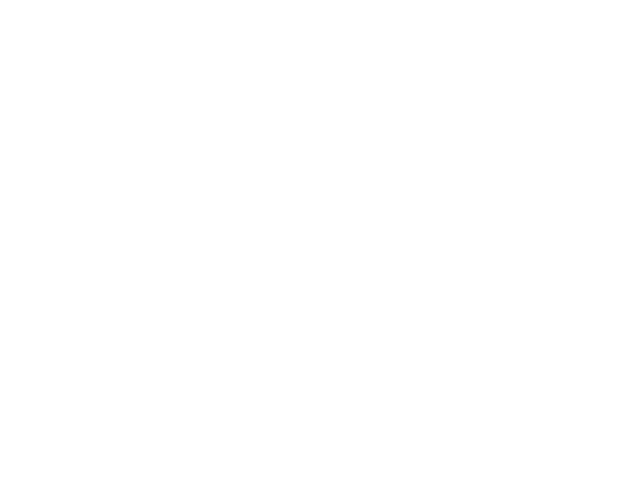

AttributeError: 'Figure' object has no attribute 'title'

In [93]:
fig = plt.figure()
ax.se


<IPython.core.display.Javascript object>


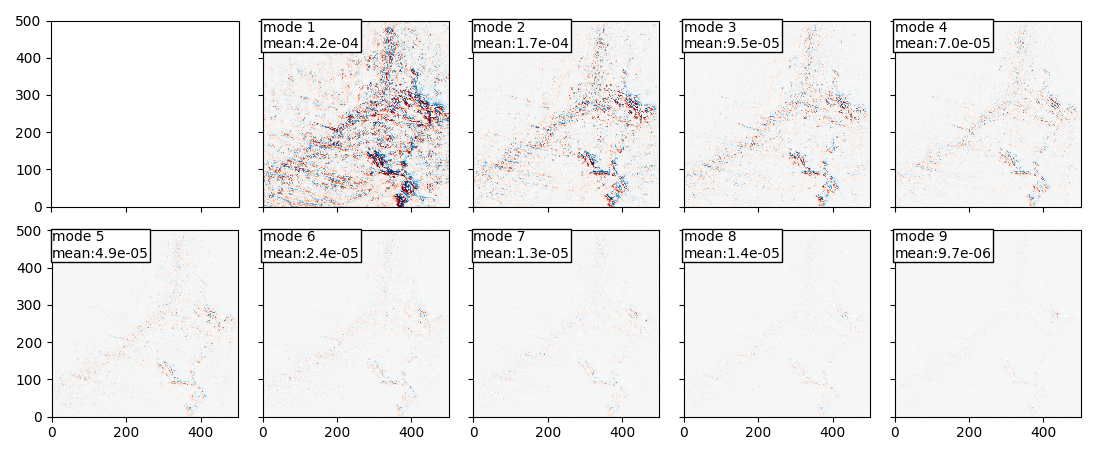

In [76]:
# plot result
fig, axs = plt.subplots(2, (nmod+1)//2, sharex=True, sharey=True, figsize=(2*(nmod+1)//2, 4.5))
for ia,ax in enumerate(axs.ravel()):
    if ia==0: continue
    toplot = np.ma.masked_where(mast,czon[ia-1,:,:])*1e3
    ax.pcolormesh(toplot, norm=norm, cmap="RdBu_r")
    ax.text(0, 1, "mode {0} \nmean:{1:.1e}".format(ia,np.nanmean(toplot)), va='top', transform=ax.transAxes, bbox=dict(facecolor="white",pad=1))
    ax.set_aspect(1)
    
fig.set_tight_layout(True)
